# 1-Normalization (num variables)

In [1]:
# Importing libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# enabling the display of all columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)



In [2]:
# Load data set

df = pd.read_pickle(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d3.pkl')

# Let's first drop the Cn variable

df = df.drop(['Cn'], axis=1)


# Check summary

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape

                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
Fuel consumption    float32            NaN                 0.0
Mt                    int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
m (kg)                int64            NaN                 0.0
target_Ewltp          int64            NaN                 0.0
year                  int64            NaN                 0.0
Country              object           29.0                 0.0
Fm                   object            7.0                 0.0
Ft                   object           10.0                 0.0
Mh                   object           49.0                 0.0


(9096945, 14)

## Data preparation of numerical variables

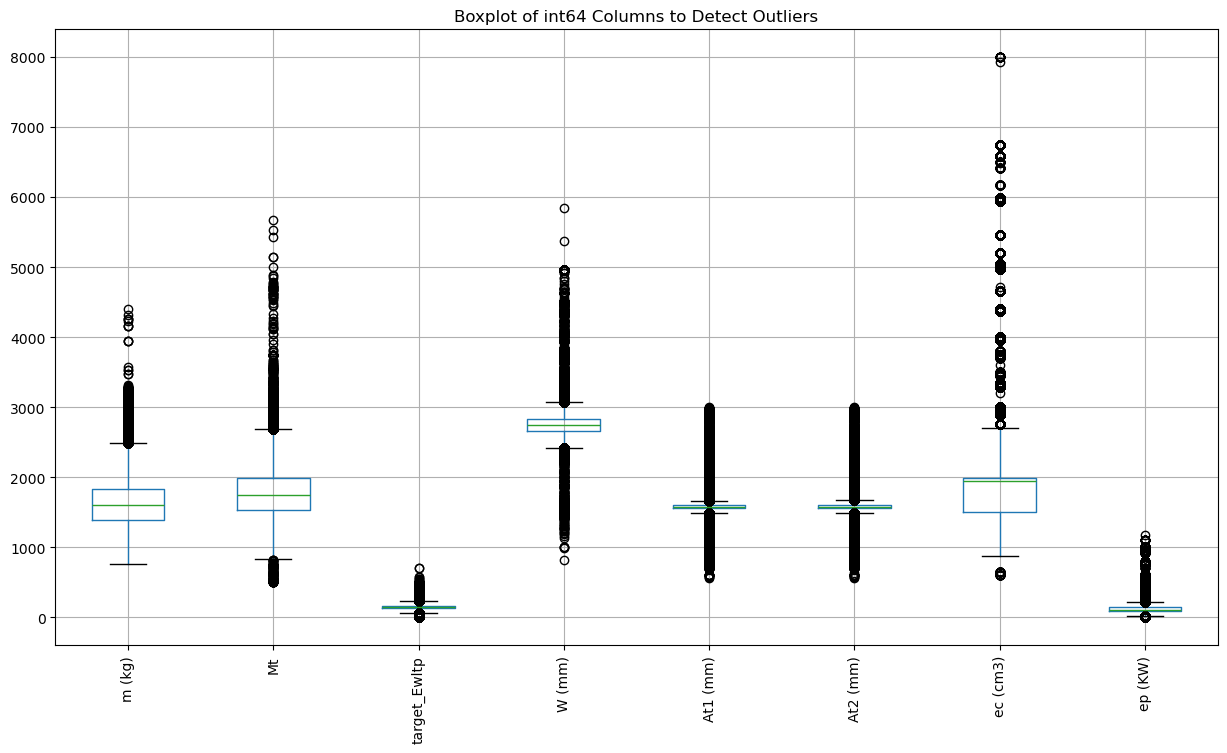

In [4]:
# Before standardizing/normalizing numerical variables, we need to deal with outliers first, since they can significantly affect the mean and standard deviation of the data 
# Let's visualize them first

# Filter for only int64 columns, but exclude year
int64_columns = df.select_dtypes(include=['int64']).columns
int64_columns = int64_columns.drop('year')


# Create boxplots for all int64 columns
plt.figure(figsize=(15, 8))
df[int64_columns].boxplot()
plt.xticks(rotation=90)  # Rotate x labels if column names are long
plt.title("Boxplot of int64 Columns to Detect Outliers")
plt.show()

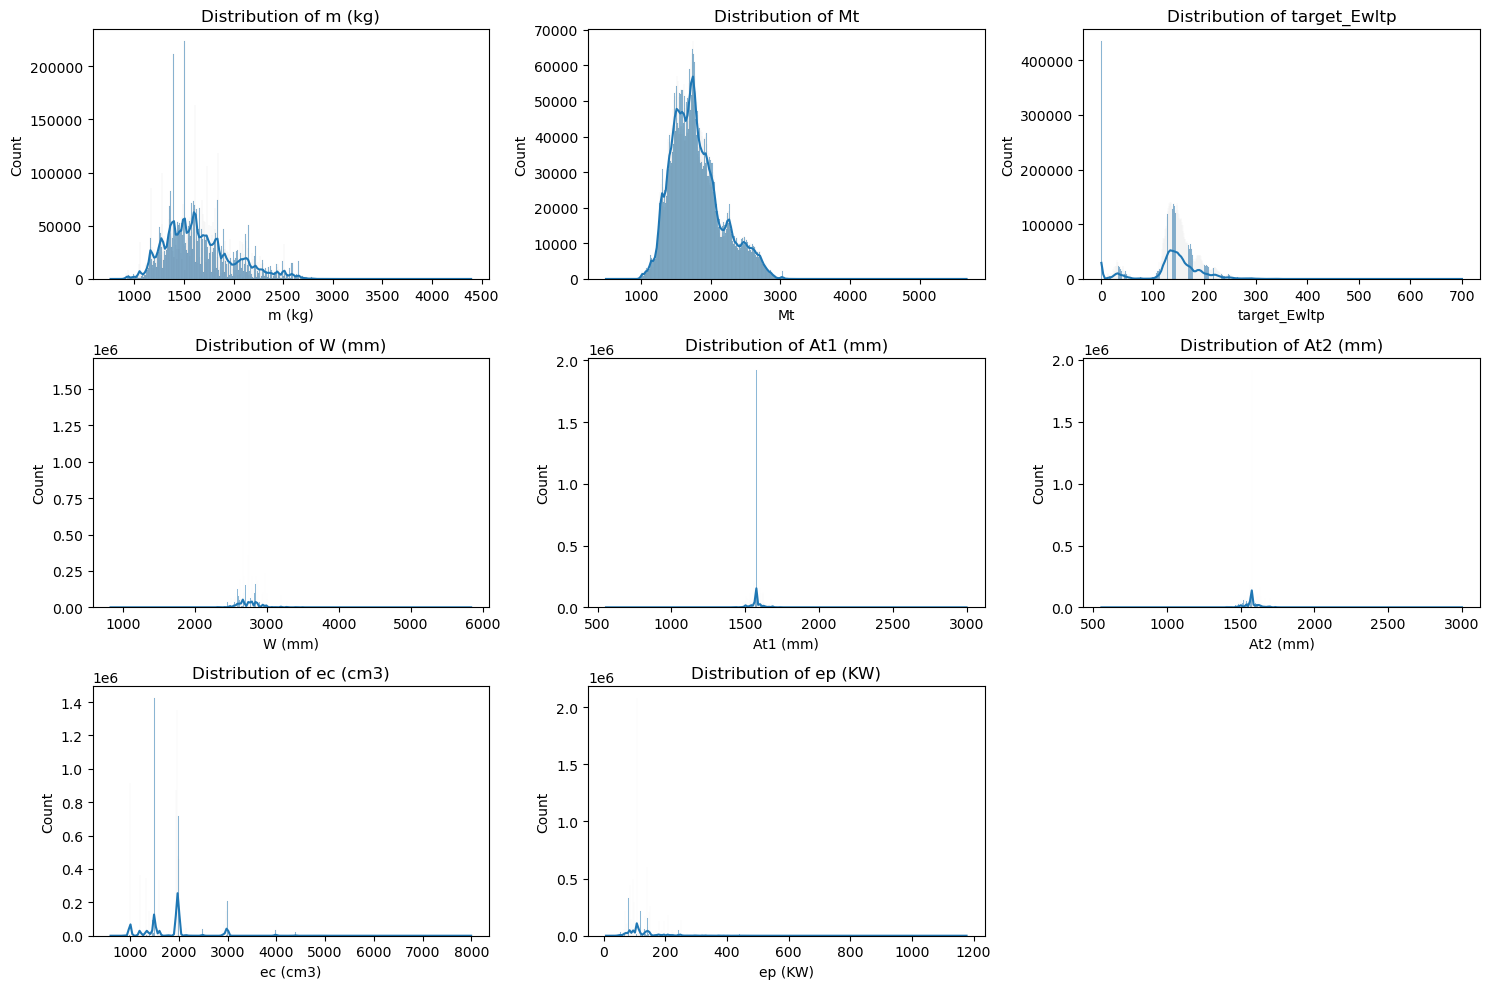

In [6]:
# Recall that Linear Models assume normality. Let's also check how normal the distribution of the num variables are

# Exclude 'year' column and select int64 columns only
int_columns = df.select_dtypes(include='int64').columns
int_columns = int_columns.drop('year')

# Plot histograms to visualize distribution of each int64 column
plt.figure(figsize=(15, 10))
for i, column in enumerate(int_columns, 1):
    plt.subplot(len(int_columns) // 3 + 1, 3, i)  # Creating subplots
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
plt.show()

Given that m, MT and the target variable seem to have a skewed distribution. The following steps will be followed:

1- Handle Outliers: Use the IQR method to handle outliers, ensuring that extreme values do not skew the model.
2- Apply Transformations: Use log transformation to reduce skewness in m, Mt and Ewltp (target variable)- already attempted in the first notebook, altough it did not drastically removed skeweness.
3- Normalize Features: Standardize or normalize the features to ensure they are on a similar scale.
4- Linear Regression: Proceed with your linear regression model after these preprocessing steps.

In [3]:
# Outliers

# Exclude 'year' column and select int64 columns only
int_columns = df.select_dtypes(include='int64').columns
int_columns = int_columns.drop('year')

# IQR method for outlier removal
Q1 = df[int_columns].quantile(0.25)
Q3 = df[int_columns].quantile(0.75)
IQR = Q3 - Q1

# Define a condition to filter out outliers
condition = ~((df[int_columns] < (Q1 - 1.5 * IQR)) | (df[int_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Apply the condition to the DataFrame to remove outliers
df_clean = df[condition]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_clean.shape}")


Original DataFrame shape: (9096945, 14)
DataFrame shape after removing outliers: (6258028, 14)


In [4]:
# Log transformation

df = df_clean

df['m (kg)'] = np.log(df['m (kg)'] + 1)  # Log transformation for the m column (to avoid log(0))
df['Mt'] = np.log(df['Mt'] + 1)
df['target_Ewltp'] = np.log(df['target_Ewltp'] + 1)



In [5]:
print(int_columns)  # This should list all the int64 columns except 'year'
print(df.dtypes)

Index(['m (kg)', 'Mt', 'target_Ewltp', 'W (mm)', 'At1 (mm)', 'At2 (mm)',
       'ec (cm3)', 'ep (KW)'],
      dtype='object')
Country               object
Mh                    object
m (kg)               float64
Mt                   float64
target_Ewltp         float64
W (mm)                 int64
At1 (mm)               int64
At2 (mm)               int64
Ft                    object
Fm                    object
ec (cm3)               int64
ep (KW)                int64
year                   int64
Fuel consumption     float32
dtype: object


In [6]:
# Normalization (note that the log transformation changed the types of the columns to floats)

from sklearn.preprocessing import StandardScaler

# Select all float-type columns (excluding the 'year' column)
float_columns = df.select_dtypes(include=['float64', 'float32']).columns
float_columns = float_columns.drop('year', errors='ignore')

# Initialize the scaler
scaler = StandardScaler()

# Standardize the selected float columns
df[float_columns] = scaler.fit_transform(df[float_columns])

# Check the result
print(df[float_columns].head())


           m (kg)        Mt  target_Ewltp  Fuel consumption 
4209886 -1.428137 -1.130074     -0.358269          -0.006837
4209887 -1.428137 -1.124927     -0.358269          -0.006837
4209888 -1.288500 -1.002453      0.300970          -0.006837
4209889 -1.288500 -0.987287      0.478404          -0.006837
4209890 -1.428137 -1.104372     -0.309054          -0.006837


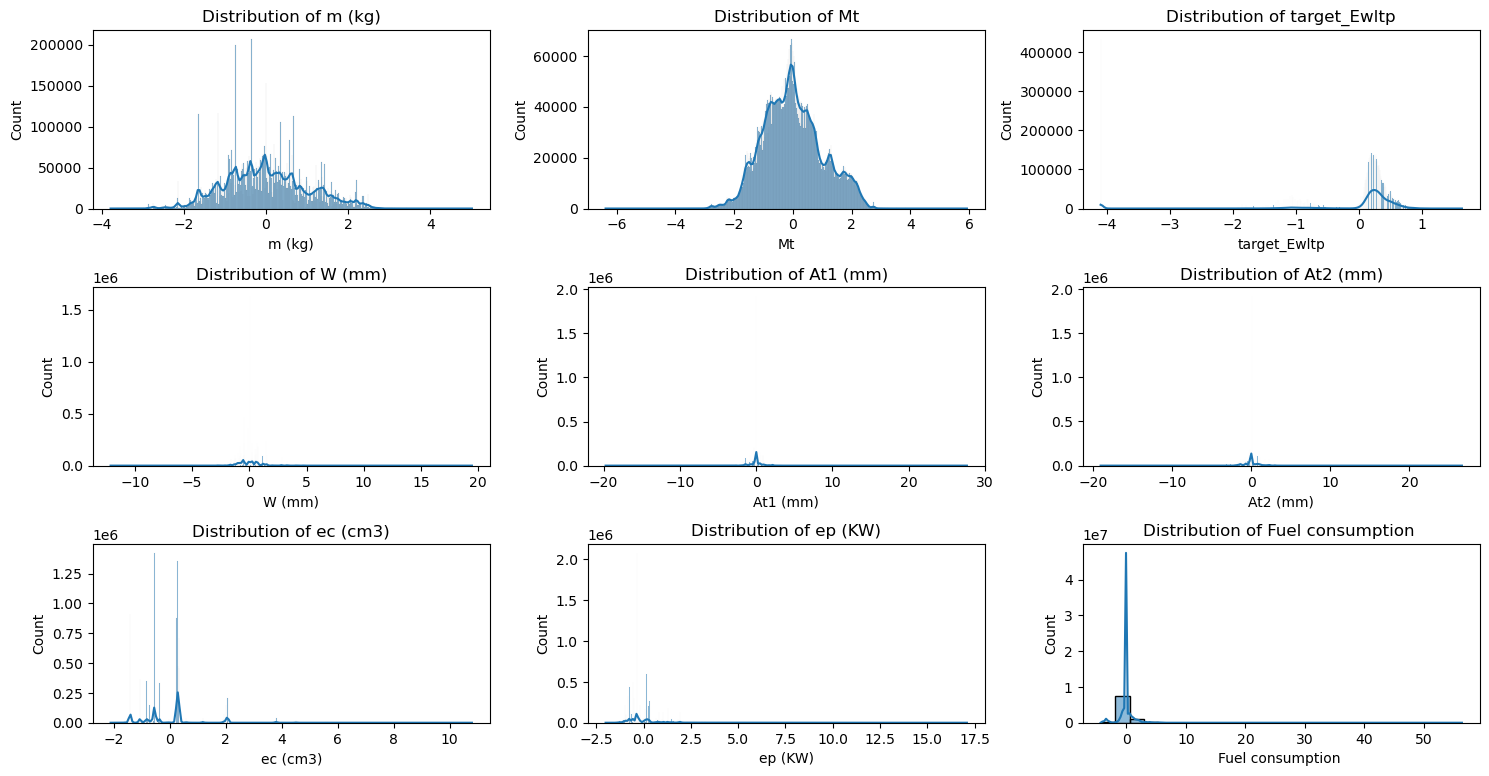

In [20]:
# Let's re-visualize 

# Exclude 'year' column and select float columns only
float_columns = df.select_dtypes(include=['float64', 'float32']).columns
float_columns = float_columns.drop('year', errors='ignore')  # Drop 'year' if present

# Plot histograms to visualize distribution of each float column
plt.figure(figsize=(15, 10))
for i, column in enumerate(float_columns, 1):
    plt.subplot(len(float_columns) // 3 + 1, 3, i)  # Creating subplots
    sns.histplot(df[column], kde=True)
    plt.title(f'Distribution of {column}')
    plt.tight_layout()
plt.show()

#It is not perfect, but it is slightly better

In [7]:
# Saving this step

df.to_pickle(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d4_normalized.pkl')
df.to_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d4_normalized.parquet', index=False)



# 2- Segway: Required further reduction of categorical variables

After all cat and num variables were prepocessed, ready  to run the regression, I saved the dataframe via pickle. The result was a df with 11 gigas size. 
I could not load the new df, because the RAM capacity ran dry. 

The main problem seems to be the encoding of categorical variables (see unique values):

0  Country            29
1       Mh            49
2       Ft            10
3       Fm             7

Each variable createds two new columns (0,1)

I explored other forms of encoding. Yet, none seem adequate for my data:

1- One-hot Ecoding: It creates binary columns for each category, allowing the model to treat them independently. However, it can lead to a high-dimensional feature space if the number of unique values is large, potentially causing issues like the "curse of dimensionality".
2- Label Encoding: This method assigns a unique integer to each category. It's useful for ordinal variables. Yet, my categories do NOT have a natural order
3- Target Encodig: This method replaces categories with the mean of the target variable for that category. It can capture relationships between the categorical variable and the target. This method can lead to overfitting, especially if the categories have few observations.
4- Frequency Encoding: This method replaces each category with its frequency in the dataset. It can be useful to preserve some information about the category's importance. However, It doesn’t capture the relationship between the categorical variable and the target.

So, the best method is still One-Hot Encoding. Let's see if it gets unmanageable.

The step that remains is the reduction of categorical variables (e.g.) country. 


In [3]:

import pandas as pd
import numpy as np

df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d4_normalized.parquet')


In [4]:
# Select object-type columns
object_columns = df.select_dtypes(include='object').columns

# Create a dictionary to store the unique counts
unique_counts = {col: df[col].nunique() for col in object_columns}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Count'])

# Display the result
print(unique_counts_df) 


    Column  Unique Count
0  Country            29
1       Mh            39
2       Ft             8
3       Fm             5


In [5]:
# Check Which Countries Form 80% of the Data
# Calculate the frequency of each country

country_counts = df['Country'].value_counts()

# Calculate the cumulative percentage of entries for each country
country_percentage = (country_counts / country_counts.sum()).cumsum() * 100

# Filter to get the countries that form the first 80% of entries
countries_80_percent = country_percentage[country_percentage <= 80]

# Print the countries and their cumulative percentages
print(countries_80_percent)

# Visualize the cumulative distribution of countries
plt.figure(figsize=(10, 6))
plt.plot(country_percentage.index, country_percentage.values, marker='o', linestyle='-')
plt.axhline(80, color='r', linestyle='--', label='80% threshold')
plt.xticks(rotation=45)
plt.title('Cumulative Distribution of Country Entries')
plt.xlabel('Country')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Country
DE    36.337230
FR    46.247556
IT    54.654949
BE    61.581875
PL    67.302479
ES    72.377768
AT    77.144765
Name: count, dtype: float64


NameError: name 'plt' is not defined

In [15]:
#We can retain the countries forming 80% of the data and drop the rest. Thereby reducing significantly the number of extra columns that encoding will produce 

# List of countries to retain
countries_to_keep = ['DE', 'FR', 'IT', 'BE', 'PL', 'AT', 'ES', 'GB']

# Filter the DataFrame to retain only rows where 'Country' is in the list of countries_to_keep
filtered_df = df[df['Country'].isin(countries_to_keep)]

# Check the shape of the filtered DataFrame to ensure the filtering worked
print("Shape of the filtered DataFrame:", filtered_df.shape)

####
# Check overall state

df = filtered_df

# Select object-type columns
object_columns = df.select_dtypes(include='object').columns

# Create a dictionary to store the unique counts
unique_counts = {col: df[col].nunique() for col in object_columns}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Count'])

# Display the result
print(unique_counts_df) 


Shape of the filtered DataFrame: (5049268, 14)
    Column  Unique Count
0  Country             8
1       Mh            37
2       Ft             8
3       Fm             5


Mh
volkswagen    18.673439
BMW           33.258960
audi          45.768198
skoda         55.668762
mercedes      63.729733
ford          69.100194
seat          73.727083
renault       77.628797
Name: count, dtype: float64


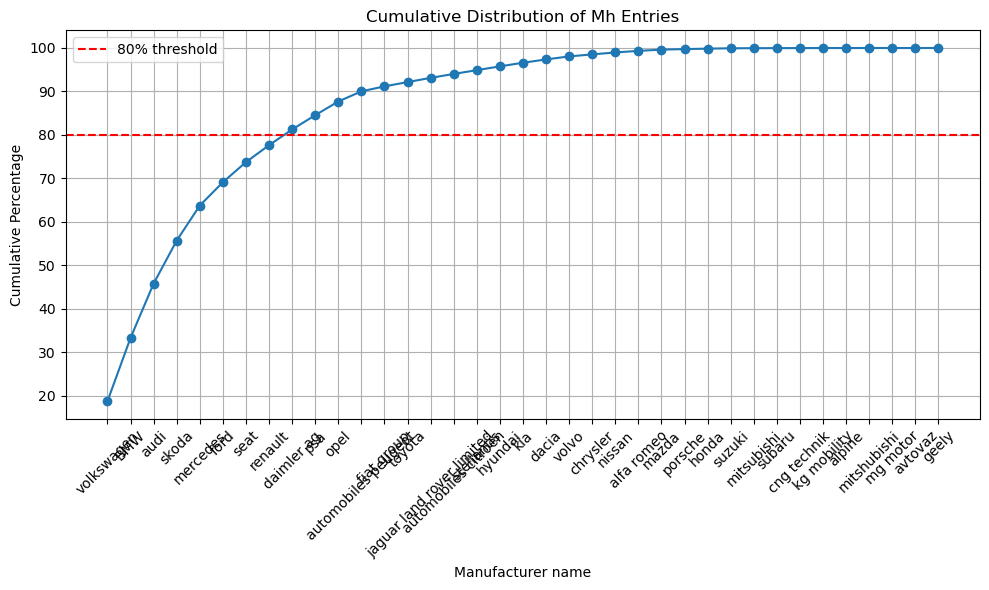

In [17]:
# Mh
# Let's perform the same analysis here with the manufacturers make up the biggest share of the data

# Calculate the frequency 

Mh_counts = df['Mh'].value_counts()

# Calculate the cumulative percentage of entries for each country
Mh_percentage = (Mh_counts / Mh_counts.sum()).cumsum() * 100

# Filter to get the countries that form the first 80% of entries
Mh_80_percent = Mh_percentage[Mh_percentage <= 80]

# Print the countries and their cumulative percentages
print(Mh_80_percent)

# Visualize the cumulative distribution of countries
plt.figure(figsize=(10, 6))
plt.plot(Mh_percentage.index, Mh_percentage.values, marker='o', linestyle='-')
plt.axhline(80, color='r', linestyle='--', label='80% threshold')
plt.xticks(rotation=45)
plt.title('Cumulative Distribution of Mh Entries')
plt.xlabel('Manufacturer name')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [18]:
# Let's keep these 8 and drop the rest

# List of manufacturers  to retain
Mh_to_keep = ['BMW', 'volkswagen', 'audi', 'mercedes', 'skoda', 'ford', 'seat', 'renault']

# Filter the DataFrame to retain only rows where 'Mh' is in the list of countries_to_keep
filtered_df = df[df['Mh'].isin(Mh_to_keep)]

# Optional: Check the shape of the filtered DataFrame to ensure the filtering worked
print("Shape of the filtered DataFrame:", filtered_df.shape)

###

# Check overall state

df = filtered_df

# Select object-type columns
object_columns = df.select_dtypes(include='object').columns

# Create a dictionary to store the unique counts
unique_counts = {col: df[col].nunique() for col in object_columns}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Count'])

# Display the result
print(unique_counts_df) 


Shape of the filtered DataFrame: (3919686, 14)
    Column  Unique Count
0  Country             8
1       Mh             8
2       Ft             8
3       Fm             5


Ft
gasoline    49.749444
Name: count, dtype: float64


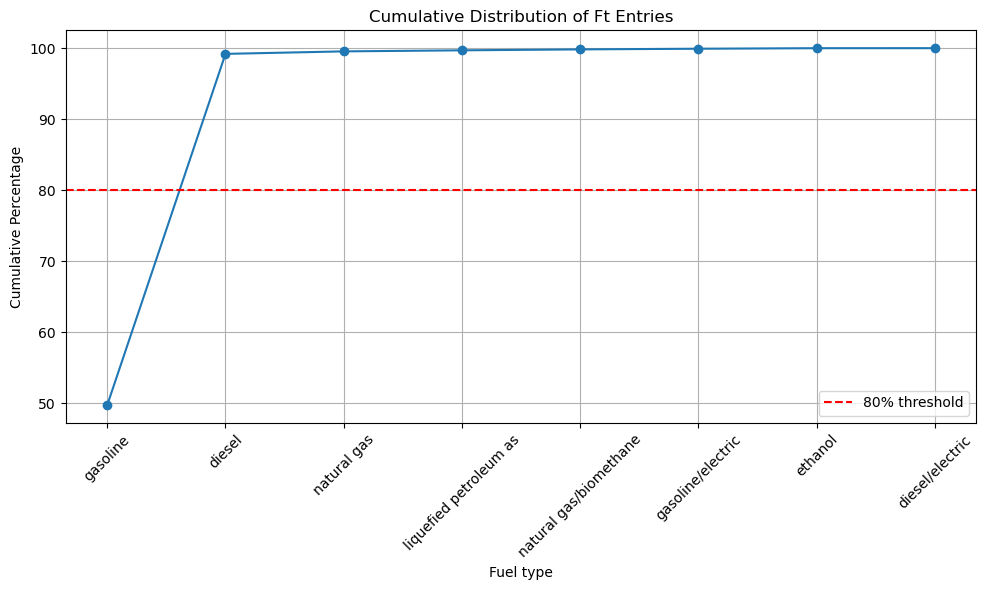

In [19]:
# Ft
# Let's perform the same analysis here with fuel type 

# Calculate the frequency 

Ft_counts = df['Ft'].value_counts()

# Calculate the cumulative percentage of entries for each country
Ft_percentage = (Ft_counts / Ft_counts.sum()).cumsum() * 100

# Filter to get the countries that form the first 80% of entries
Ft_80_percent = Ft_percentage[Ft_percentage <= 80]

# Print the countries and their cumulative percentages
print(Ft_80_percent)

# Visualize the cumulative distribution of countries
plt.figure(figsize=(10, 6))
plt.plot(Ft_percentage.index, Ft_percentage.values, marker='o', linestyle='-')
plt.axhline(80, color='r', linestyle='--', label='80% threshold')
plt.xticks(rotation=45)
plt.title('Cumulative Distribution of Ft Entries')
plt.xlabel('Fuel type')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
# Let's keep the first 2 

# List to retain
Ft_to_keep = ['diesel', 'gasoline']

# Filter the DataFrame to retain only rows where 'Mh' is in the list of countries_to_keep
filtered_df = df[df['Ft'].isin(Ft_to_keep)]

# Optional: Check the shape of the filtered DataFrame to ensure the filtering worked
print("Shape of the filtered DataFrame:", filtered_df.shape)

###

# Check overall state

df = filtered_df

# Select object-type columns
object_columns = df.select_dtypes(include='object').columns

# Create a dictionary to store the unique counts
unique_counts = {col: df[col].nunique() for col in object_columns}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Count'])

# Display the result
print(unique_counts_df) 

Shape of the filtered DataFrame: (3888204, 14)
    Column  Unique Count
0  Country             8
1       Mh             8
2       Ft             2
3       Fm             2


Series([], Name: count, dtype: float64)


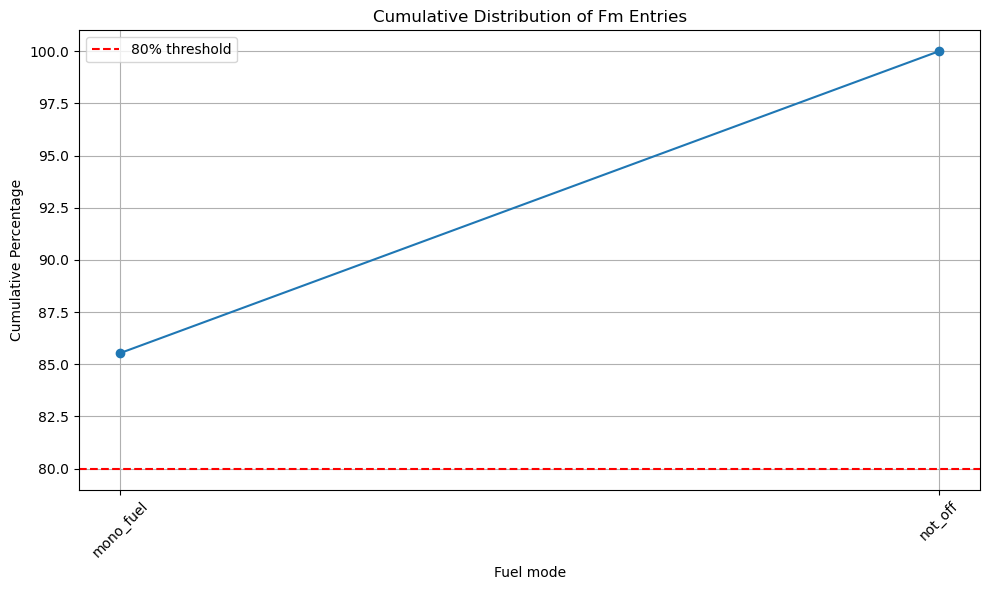

In [21]:
# Fm
# Same with Fuel mode

# Calculate the frequency 

Fm_counts = df['Fm'].value_counts()

# Calculate the cumulative percentage of entries for each country
Fm_percentage = (Fm_counts / Fm_counts.sum()).cumsum() * 100

# Filter to get the countries that form the first 80% of entries
Fm_80_percent = Fm_percentage[Fm_percentage <= 80]

# Print the countries and their cumulative percentages
print(Fm_80_percent)

# Visualize the cumulative distribution
plt.figure(figsize=(10, 6))
plt.plot(Fm_percentage.index, Fm_percentage.values, marker='o', linestyle='-')
plt.axhline(80, color='r', linestyle='--', label='80% threshold')
plt.xticks(rotation=45)
plt.title('Cumulative Distribution of Fm Entries')
plt.xlabel('Fuel mode')
plt.ylabel('Cumulative Percentage')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [22]:

# List to retain
Fm_to_keep = ['mono_fuel', 'not_off']

# Filter the DataFrame to retain only rows where 'Fm' is in the list of Fm_to_keep
filtered_df = df[df['Fm'].isin(Fm_to_keep)]

# Optional: Check the shape of the filtered DataFrame to ensure the filtering worked
print("Shape of the filtered DataFrame:", filtered_df.shape)


###

# Check overall state

df = filtered_df

# Select object-type columns
object_columns = df.select_dtypes(include='object').columns

# Create a dictionary to store the unique counts
unique_counts = {col: df[col].nunique() for col in object_columns}

# Convert to DataFrame for better visualization
unique_counts_df = pd.DataFrame(unique_counts.items(), columns=['Column', 'Unique Count'])

# Display the result
print(unique_counts_df) 

Shape of the filtered DataFrame: (3888204, 14)
    Column  Unique Count
0  Country             8
1       Mh             8
2       Ft             2
3       Fm             2


In [ ]:
# We were able to drastically the number of values in the categorical values while retaining 80-90% of the information. Thereby, hopelly being able to produce a cleaned dataset
# that is manageable.

In [23]:
# Check summary (prenving that missing values have been re-introduced)

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape

                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
year                  int64            NaN                 0.0
Fuel consumption    float64            NaN                 0.0
Mt                  float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
target_Ewltp        float64            NaN                 0.0
Country              object            8.0                 0.0
Fm                   object            2.0                 0.0
Ft                   object            2.0                 0.0
Mh                   object            8.0                 0.0


(3888204, 14)

In [25]:
#Let's save this df before moving onto encoding, which is re-introducing NANs

df.to_pickle(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d5_normalized.pkl')
df.to_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d5_normalized.parquet', index=False)


# 3- Encoding _ via get_dummies (cat variables) 

Given the moderate number of unique values, I need to review different encoding methods. Here is an overview list:

1- One-hot Ecoding: It creates binary columns for each category, allowing the model to treat them independently. However, it can lead to a high-dimensional feature space if the number of unique values is large, potentially causing issues like the "curse of dimensionality".
2- Label Encoding: This method assigns a unique integer to each category. It's useful for ordinal variables. Yet, my categories do NOT have a natural order
3- Target Encodig: This method replaces categories with the mean of the target variable for that category. It can capture relationships between the categorical variable and the target. This method can lead to overfitting, especially if the categories have few observations.
4- Frequency Encoding: This method replaces each category with its frequency in the dataset. It can be useful to preserve some information about the category's importance. However, It doesn’t capture the relationship between the categorical variable and the target.

So, the best method is still One-Hot Encoding. Let's see if it gets unmanageable
**
One-Hot Econding kept introducing NaN. I decided to try get_dummies.

Missing Values vs. Zeros:

Missing values are different from zeros. Missing values (NaNs) indicate an absence of data, while zeros in one-hot encoded columns just indicate that the category is not present in that observation.
The summary report you are using (df.isnull().mean() * 100) is intended to check for NaNs, not zeros. If it shows that there are missing values (NaNs), those are genuine missing values, unrelated to the zeros introduced by one-hot encoding.

I am trying with get_dummies. 

In [20]:

import pandas as pd
import numpy as np


# Re-load
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d5_normalized.parquet')

# double check

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape


                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
year                  int64            NaN                 0.0
Fuel consumption    float64            NaN                 0.0
Mt                  float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
target_Ewltp        float64            NaN                 0.0
Country              object            8.0                 0.0
Fm                   object            2.0                 0.0
Ft                   object            2.0                 0.0
Mh                   object            8.0                 0.0


(3888204, 14)

In [21]:
# As seen above, no missing values are present. Let's try with get_dummies instead of OneHotEncoder, which introduces NaNs

categorical_cols = ['Country', 'Mh', 'Ft', 'Fm']

# Use pd.get_dummies to one-hot encode these columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=False)

# Let's tranform the boolean to int


# Double check summary

df = df_encoded

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape



                  Data Type  Unique Values  Missing Values (%)
Fm_not_off             bool            NaN                 0.0
Mh_ford                bool            NaN                 0.0
Mh_audi                bool            NaN                 0.0
Mh_BMW                 bool            NaN                 0.0
Mh_seat                bool            NaN                 0.0
Ft_gasoline            bool            NaN                 0.0
Ft_diesel              bool            NaN                 0.0
Mh_volkswagen          bool            NaN                 0.0
Fm_mono_fuel           bool            NaN                 0.0
Country_PL             bool            NaN                 0.0
Country_IT             bool            NaN                 0.0
Country_GB             bool            NaN                 0.0
Country_FR             bool            NaN                 0.0
Country_ES             bool            NaN                 0.0
Country_DE             bool            NaN             

(3888204, 30)

In [22]:
# Let save this file

df.to_pickle(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_get_dummied.pkl')
df.to_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_get_dummied.parquet', index=False)


# 4- Encoding _ via HotEncoder (cat variables) 

In [4]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import OneHotEncoder

# Re-load
df=pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d5_normalized.parquet')

# double check

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape




                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
year                  int64            NaN                 0.0
Fuel consumption    float64            NaN                 0.0
Mt                  float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
target_Ewltp        float64            NaN                 0.0
Country              object            8.0                 0.0
Fm                   object            2.0                 0.0
Ft                   object            2.0                 0.0
Mh                   object            8.0                 0.0


(3888204, 14)

In [9]:
# Define the categorical columns
#categorical_cols = ['Country', 'Mh', 'Ft', 'Fm']

# Initialize the OneHotEncoder
#encoder = OneHotEncoder(sparse_output=False, drop='first')  # drop='first' to avoid dummy variable trap

# Fit and transform the categorical columns
#encoded_array = encoder.fit_transform(df[categorical_cols])

# Create a DataFrame with the encoded variables
#encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(categorical_cols))

# Drop the original categorical columns from the DataFrame
#df_encoded = df.drop(categorical_cols, axis=1)

# Concatenate the original DataFrame with the encoded DataFrame
#df_encoded = pd.concat([df_encoded, encoded_df], axis=1)


# Double check summary

df = df_encoded

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)



                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
year                  int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
Country_FR          float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
Country_BE          float64            NaN                 0.0
Country_DE          float64            NaN                 0.0
Mt                  float64            NaN                 0.0
Mh_volkswagen       float64            NaN                 0.0
Mh_skoda            float64            NaN                 0.0
Mh_seat             float64            NaN                 0.0
Country_ES          float64            NaN             

(3888204, 26)

In [10]:
df.head()

,m (kg),Mt,target_Ewltp,W (mm),At1 (mm),At2 (mm),ec (cm3),ep (KW),year,Fuel consumption,...,Country_PL,Mh_audi,Mh_ford,Mh_mercedes,Mh_renault,Mh_seat,Mh_skoda,Mh_volkswagen,Ft_gasoline,Fm_not_off
0,0.96352,1.004266,0.985092,2864,1620,1636,1995,100,2019,-0.006837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.96352,0.701616,0.820259,2864,1620,1636,1995,100,2019,-0.006837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.96352,0.693586,0.820259,2864,1620,1636,1995,100,2019,-0.006837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.96352,0.992705,0.903163,2864,1620,1636,1995,110,2019,-0.006837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.96352,0.895649,0.903163,2864,1620,1636,1995,100,2019,-0.006837,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
# Let's save this one too

df.to_pickle(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.pkl')
df.to_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet', index=False)

# 5- Linear Regression using HotEncoded (cat variables)- addressing collinearity

In [1]:
# Import libraries

import pandas as pd
import numpy as np
import statsmodels.api as sm

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt
import seaborn as sns



In [2]:
# reading the file

import os

file_path = r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet'

if os.path.exists(file_path):
    print("File exists!")
else:
    print("File not found, check the path.")


df = pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet')


File exists!


In [3]:
# Double check summary

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape

                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
year                  int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
Country_FR          float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
Country_BE          float64            NaN                 0.0
Country_DE          float64            NaN                 0.0
Mt                  float64            NaN                 0.0
Mh_volkswagen       float64            NaN                 0.0
Mh_skoda            float64            NaN                 0.0
Mh_seat             float64            NaN                 0.0
Country_ES          float64            NaN             

(3888204, 26)

In [ ]:
# Workflow 

#1 - Import Necessary Libraries
#2 - Define Features and Target Variable
#3 - Split Data into Training and Testing Sets
#4 - Fit the Linear Regression Model (using LinearRegression from scikit-learn and the OLS from statsmodels)
#5 - Evaluate Model Performance
#6 - Calculate Additional Metrics (p-value)

In [4]:
# Step 3: Define Features and Target Variable

X = df.drop(columns=['target_Ewltp'])  # Features
y = df['target_Ewltp']  # Target variable

# Step 4: Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Step 5: Fit the Linear Regression Model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [6]:
# Predict on the test set
y_pred = model.predict(X_test)

In [7]:
# Step 6: Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared:", r2)

Mean Squared Error: 0.18232316832258325
R-squared: 0.8028913155691902


In [8]:
# Let's get the p value using the python library 
# Add constant (intercept)
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the OLS model
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Check the summary
print(model_sm.summary())


                            OLS Regression Results                            
Dep. Variable:           target_Ewltp   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 5.085e+05
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:00:06   Log-Likelihood:            -1.7656e+06
No. Observations:             3110563   AIC:                         3.531e+06
Df Residuals:                 3110537   BIC:                         3.531e+06
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               334.2970      0.37

Interpretation:

An R² value of 0.8023 means that approximately 80.23% of the variance in the target variable is explained by the features in the  model. 
This is generally considered a good value. Both models deliver the same scoring. 
MSE (the average squared difference between the predicted and actual values). A lower MSE indicates better model performance, as it means the predictions are closer to the actual values.

However, there is a warning regarding the presence of multicollinearity in the OLS model. 

Literature:

The condition number is a measure of how sensitive the output of a function is to changes in the input. In the context of regression, it indicates the potential for multicollinearity among your predictors.
A large condition number (typically above 30) suggests that the model may have issues with multicollinearity or other numerical stability problems. In your case, 6.85e+06 (which is 6,850,000) is indeed very large, indicating significant multicollinearity.

Multicollinearity: High multicollinearity means that two or more predictor variables are highly correlated, which can lead to:
Unstable estimates of regression coefficients (they can vary significantly with small changes in the data).
Difficulty in interpreting the effect of individual predictors.
Inflated standard errors, making it harder to determine the statistical significance of predictors.
Numerical Problems: It may also suggest that the matrix of predictors is close to being singular, which can lead to computational difficulties.


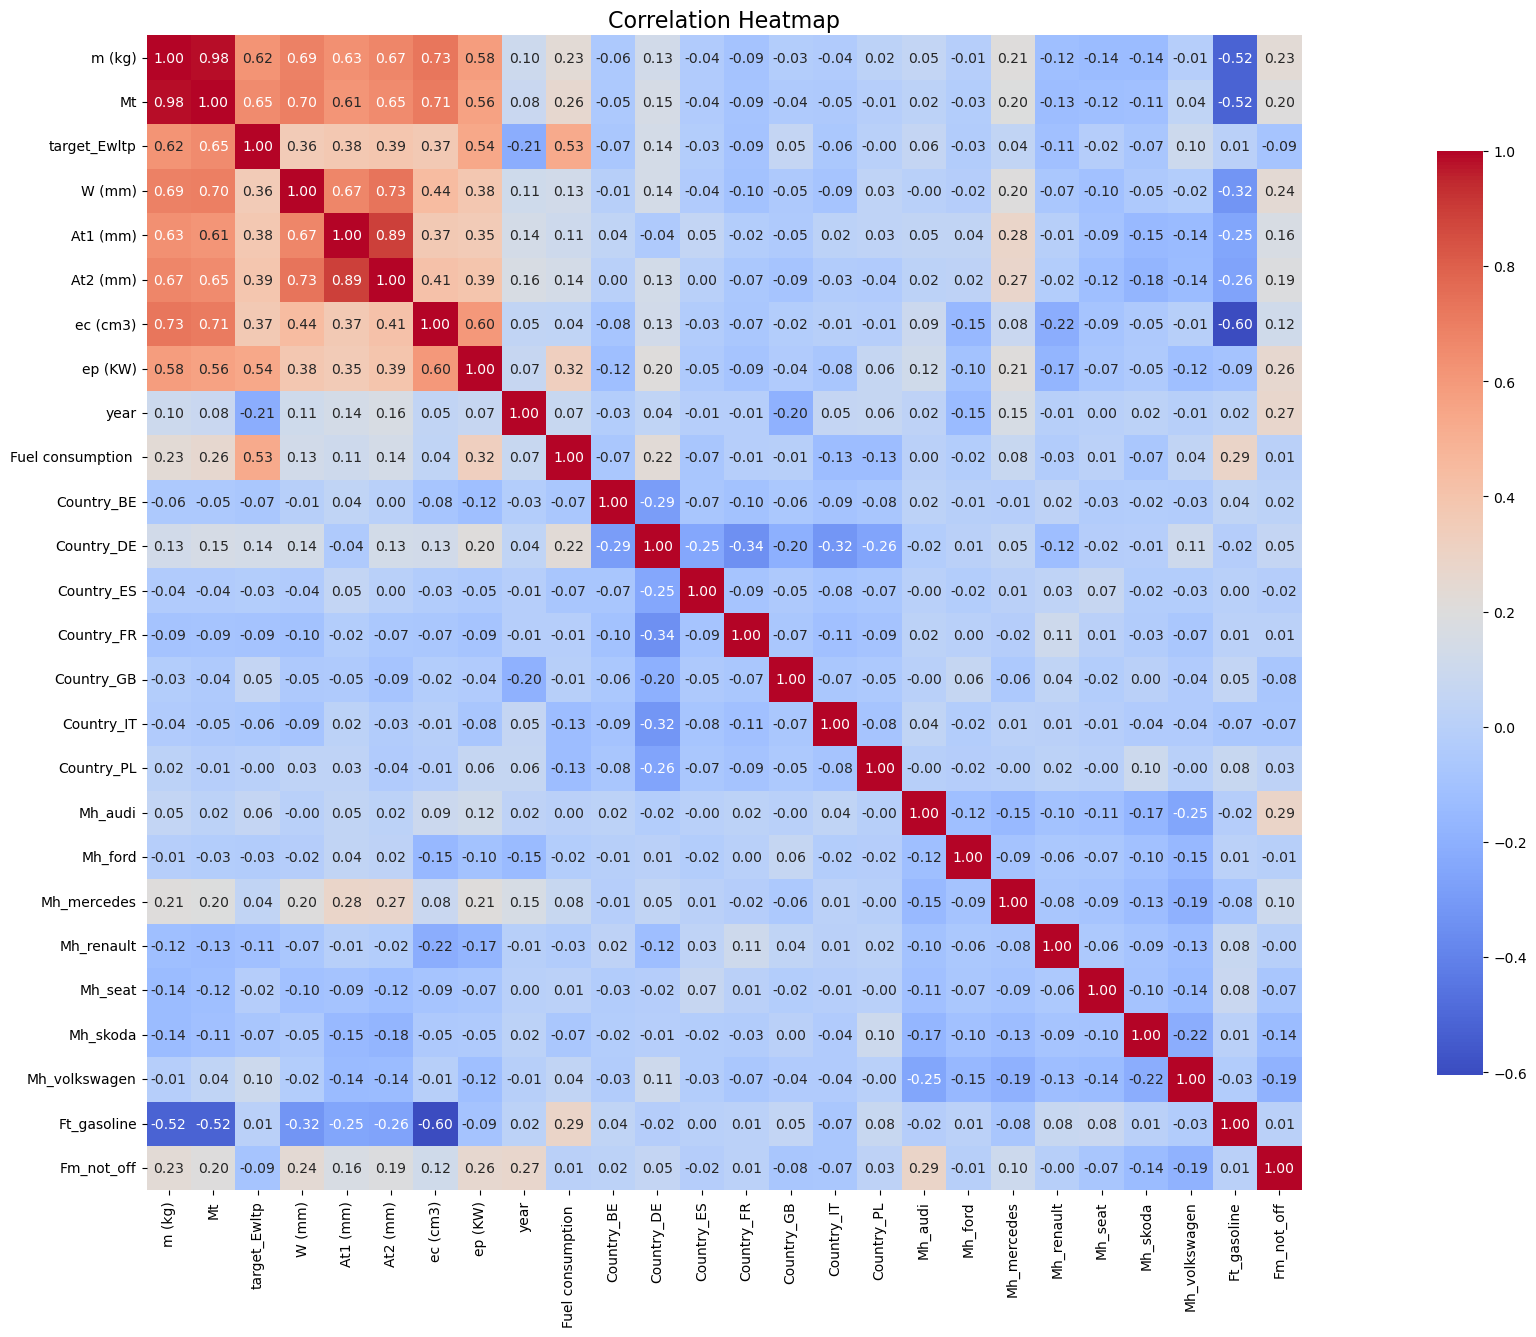

In [13]:
# Checking for collinearity 

# Calculate the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(35, 15))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap', fontsize=16)

# Show the plot
plt.show()

Interpreation: 
- Mt (WLTP test mass) and m (kg) shows a correlation of 0.98. Which makes sense, as Wltp test mass (Mt) is simply the same mass in running order (m) with some added weight, so that the testing conditions are closer to reality. m (kg), will be removed 
- At2 (mm) and At1 (mm) shows a correlation of 0,89. This is also perfectly understandable as thease are measurements of the front and rear axel of the vehicle. At2 will be removed.

In [14]:
# Remove the specified columns
df_cleaned = df.drop(columns=['m (kg)', 'At2 (mm)'])

# Display the cleaned DataFrame shape
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

Cleaned DataFrame shape: (3888204, 24)


In [15]:
# Re-running the model

# Define your target and features
X = df_cleaned.drop(columns=['target_Ewltp'])
y = df_cleaned['target_Ewltp']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Add a constant to the features for the statsmodels regression
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)

# Fit the OLS model
model_sm = sm.OLS(y_train, X_train_sm).fit()

# Print the summary of the model
print(model_sm.summary())

                            OLS Regression Results                            
Dep. Variable:           target_Ewltp   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.803
Method:                 Least Squares   F-statistic:                 5.501e+05
Date:                Sun, 13 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:39:12   Log-Likelihood:            -1.7713e+06
No. Observations:             3110563   AIC:                         3.543e+06
Df Residuals:                 3110539   BIC:                         3.543e+06
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               329.9998      0.37

In [16]:
# Make predictions on the test set
y_pred = model_sm.predict(X_test_sm)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.18301498897830792
R-squared: 0.8021433916461556


Interpretation:

The second run has still a good R-squared score of 80%. We can also reject the Null hypothesis given the P values encountered. 
However, there seems to be still multicollinearity. 

Let's recheck 

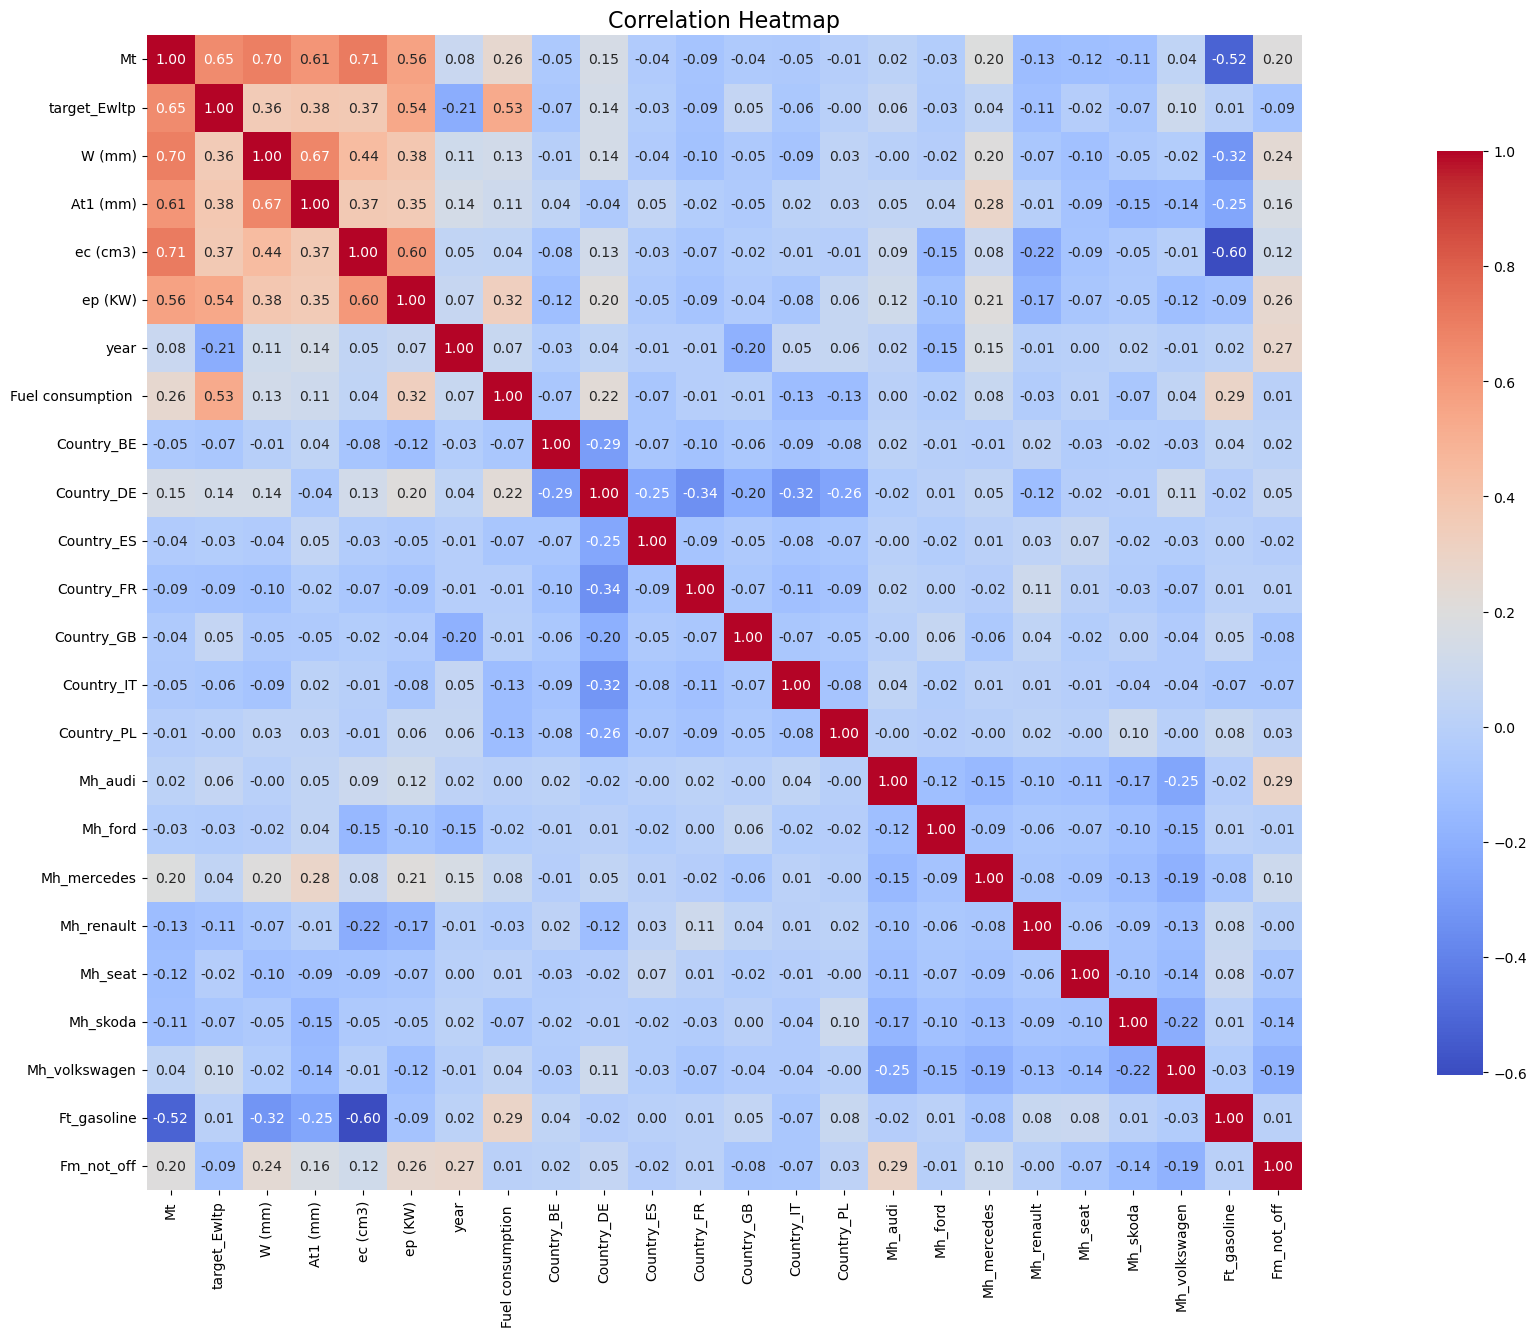

In [17]:
# Checking for collinearity 

# Calculate the correlation matrix
correlation_matrix = df_cleaned.corr()

# Set up the matplotlib figure
plt.figure(figsize=(35, 15))

# Create a heatmap
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Set the title
plt.title('Correlation Heatmap', fontsize=16)

# Show the plot
plt.show()

Interpreation:

A correlation of 0.71 between engine capacity (ec (cm3)) and test mass (Mt) is indeed considered relatively high. 
However, instead of removing one or combining both variables, I will rather test other models such as: Decision Trees, Random Forests, or Gradient Boosting, which are less sensitive to multicollinearity. 
Thereafter, probably using regularization techniques (Ridge and Lasso)


# 6 - Decision Trees: Leaving all variables removed during regression - pruning

In [1]:
# Import libraries 

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from sklearn import tree


In [2]:
# Load file

df = pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet')


In [3]:
# Double check summary

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape

                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
year                  int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
Country_FR          float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
Country_BE          float64            NaN                 0.0
Country_DE          float64            NaN                 0.0
Mt                  float64            NaN                 0.0
Mh_volkswagen       float64            NaN                 0.0
Mh_skoda            float64            NaN                 0.0
Mh_seat             float64            NaN                 0.0
Country_ES          float64            NaN             

(3888204, 26)

Workflow:

1-Import Necessary Libraries
2- Data Preparation
        Split dataset into features and target variable.
        Split the data into training and testing sets.
3-Train a Decision Tree Model
4-Make Predictions
5-Evaluate the Model
6-Visualize the Decision Tree (optional)


In [3]:
# Data preparation

X = df.drop(columns=['target_Ewltp'])  # Features
y = df['target_Ewltp']  # Target variable

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Train a Decision Tree Model
dt_model = DecisionTreeRegressor(random_state=42)
dt_model.fit(X_train, y_train)

# Step 4: Make Predictions
y_pred = dt_model.predict(X_test)

# Step 5: Evaluate the Model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

# Step 6: Visualize the Decision Tree 

#plt.figure(figsize=(20,10))
#tree.plot_tree(dt_model, filled=True, feature_names=X.columns, rounded=True)
#plt.title('Decision Tree Visualization')
#plt.show()

Mean Squared Error: 0.01885301284604609
R-squared: 0.9796181001359825


Interpretation:

The very high R-squared score (close to 1) indicates that the model fits the training data very well. However, it is also a red flag for overfitting - especially in Decision Trees, which are prone to capturing noise in the training data when left unconstrained.

Yet, the MSE is very low, which further indicates that the model performs exceptionally well on the test set. 


In [4]:
#Let's compare performance on the training set vs. test set regarding MSE

y_train_pred = dt_model.predict(X_train)
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training MSE: {mse_train}")
print(f"Training R-squared: {r2_train}")

Training MSE: 0.006180559981766522
Training R-squared: 0.9933309429445265


Interpretation:

With the R-squared of 0.9933 indicating that the Decision Tree model is explaining 99.33% of the variance in the training set and an extremely low MSE on the training set (which suggests that the model is performing almost perfectly on the training data), I can safely conclude  that the model is overfitting. 

Next steps will be pruning and cross-validation

In [5]:
#Pruning

dt_model = DecisionTreeRegressor(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

y_pred = dt_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 0.2662094106121208
R-squared: 0.712202309823743


Interpretation:

The R-squared value of 0.7122 means that the model is now explaining 71.22% of the variance in the test data. This is a lower value than before pruning (R-squared values in the 0.98–0.99 range), but it suggests a more realistic fit to the data.

The MSE is now higher compared to before pruning, which indicates that the model has a higher error on the test data after simplifying the tree.


In [6]:
# Cross validation
from sklearn.model_selection import cross_val_score
scores = cross_val_score(dt_model, X, y, cv=5, scoring='r2')
print(f"Cross-validated R-squared: {scores.mean()}")



Cross-validated R-squared: 0.6486361150311091


Interpretation: 
- R-squared value of 0.6486 means that, on average, the Decision Tree model explains about 64.86% of the variance in the target variable across different splits of the data
- The cross-validated R-squared (0.6486) is lower than your test R-squared after pruning (0.7122) and much lower than the initial overfitted model's R-squared (0.99+). This indicates that even with pruning, your model might be slightly overfitting the data or not capturing the complexity well enough. It also highlights that, on average, the model generalizes less effectively when evaluated across multiple different subsets of the data.
- A cross-validated R-squared of 0.6486 suggests that while the model can capture some patterns in the data, about 35.14% of the variance in the target variable is left unexplained by the model. This could imply that the model might be too simple, missing important features, or that the Decision Tree's inherent structure isn't ideal for your data.

Possible further steps:

1- Testing ensemble models (Random Forest, Gradient Boosting) 
2 - Fine-tuning the Decision Tree parameters further to enhance model performance and generalization

I will test Random forest

# 7 - Random forest

In [8]:
# Import libraries 

import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt


In [2]:
# Load file

df = pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet')

In [3]:
# Double check summary

# Get the data types of each column
data_types = df.dtypes

# Get the number of unique values for each categorical column
unique_values = df.select_dtypes(include=['category', 'object']).nunique()

# Get the percentage of missing values for each column
missing_values = df.isnull().mean() * 100

# Combine the information into a DataFrame
summary_df = pd.DataFrame({'Data Type': data_types, 'Unique Values': unique_values, 'Missing Values (%)': missing_values})

# Sort the DataFrame by 'Data Type' to group by data type
summary_df = summary_df.sort_values(by='Data Type')

# Print the summary DataFrame
print(summary_df)

df.shape

                  Data Type  Unique Values  Missing Values (%)
At1 (mm)              int64            NaN                 0.0
ep (KW)               int64            NaN                 0.0
ec (cm3)              int64            NaN                 0.0
W (mm)                int64            NaN                 0.0
year                  int64            NaN                 0.0
At2 (mm)              int64            NaN                 0.0
Country_FR          float64            NaN                 0.0
m (kg)              float64            NaN                 0.0
Country_BE          float64            NaN                 0.0
Country_DE          float64            NaN                 0.0
Mt                  float64            NaN                 0.0
Mh_volkswagen       float64            NaN                 0.0
Mh_skoda            float64            NaN                 0.0
Mh_seat             float64            NaN                 0.0
Country_ES          float64            NaN             

(3888204, 26)

Workflow for Random Forest

1- Prepare the Data:

- Split the dataset into features (X) and target (y).
- Split the data into training and testing sets.
- Ensure that categorical variables have been encoded properly.

2- Train the Random Forest Model:

- Initialize the Random Forest model.
- Train the model on the training set.

3- Evaluate the Model:

- Make predictions on the test set.
- Calculate metrics such as R-squared and Mean Squared Error (MSE).


4- Cross-Validation:

- Perform cross-validation to check the generalization of the model.

5. Hyperparameter Tuning:

- Use GridSearchCV or RandomizedSearchCV to fine-tune hyperparameters.

6. Feature Importance:

- Extract feature importance to understand which features are contributing most to the predictions.

In [5]:
# Step 1: Prepare the data

X = df.drop(columns=['target_Ewltp'])  # Features (drop the target variable)
y = df['target_Ewltp']  # Target variable

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 2: Initialize the Random Forest Regressor
# rf_model = RandomForestRegressor(random_state=42) --> This code could not but ran on my pc. Here a reduced version. Default is 100 trees, for ~3.9 million rows and 26 columns!

rf_model = RandomForestRegressor(random_state=42, n_jobs=-1, n_estimators=10)

# Step 3: Train the Random Forest model
rf_model.fit(X_train, y_train)

# Step 4: Evaluate the model on the test set
y_pred = rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE) and R-squared (R2) on test data
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test MSE: {mse}")
print(f"Test R-squared: {r2}")



Test MSE: 0.01581973613274815
Test R-squared: 0.98289736073667


Interpretation:

High R-squared: The model fits the data well, as it explains most of the variability in the target variable.
Low MSE: Predictions are close to the actual values.

However, these metrics are based on the test set. The model's performance on unseen data seems very good.

Potential Overfitting: Despite good test performance, Random Forests can overfit, especially if the training performance is even better than the test performance (e.g., a perfect or near-perfect R² on the training set). If the training R² is much higher, it could indicate overfitting, even if the test performance is strong.

Feature importance: Random Forest models allow you to analyze the importance of each feature in predicting the target. It might be useful to see which variables are driving the model's decisions.

In [10]:
# Check for overfitting

# Predictions on the training set
y_train_pred = rf_model.predict(X_train)

# Calculate MSE and R² for the training set
mse_train = mean_squared_error(y_train, y_train_pred)
r2_train = r2_score(y_train, y_train_pred)

print(f"Training MSE: {mse_train}")
print(f"Training R-squared: {r2_train}")


Training MSE: 0.007280289621082936
Training R-squared: 0.9921442932344948


Interpretation: 

Low overfitting: Since the difference between the training and test R-squared is very small (0.99 vs. 0.98), it indicates that the model generalizes well. 
If the training R² had been significantly higher than the test R², it could have suggested overfitting (where the model memorizes the training data and fails to generalize).
In this case, the small difference suggests that overfitting is minimal or not a concern. The model is complex enough to capture patterns but not overly complex to the point of overfitting.

Feature ranking:
1. Feature 1 (0.43229178752640013)
2. Feature 8 (0.2209691732377516)
3. Feature 23 (0.0638693510051872)
4. Feature 0 (0.060129768180871415)
5. Feature 6 (0.05183108895380156)
6. Feature 2 (0.03582555584357018)
7. Feature 5 (0.03364838110930023)
8. Feature 7 (0.031051889429995046)
9. Feature 24 (0.024989355282147276)
10. Feature 3 (0.015014039934763721)
11. Feature 4 (0.010478149777539882)
12. Feature 15 (0.003240821228283412)
13. Feature 16 (0.0025491359784148887)
14. Feature 17 (0.0024652681322964503)
15. Feature 22 (0.002153880519949824)
16. Feature 10 (0.0019510742637998475)
17. Feature 18 (0.0014963470007497881)
18. Feature 19 (0.001133852795077835)
19. Feature 11 (0.0010625459114902295)
20. Feature 20 (0.0010624992211102102)
21. Feature 21 (0.001030602403527947)
22. Feature 14 (0.0009110948616876987)
23. Feature 9 (0.0003102504633105094)
24. Feature 13 (0.000283543000474107)
25. Feature 12 (0.0002505439384990633)


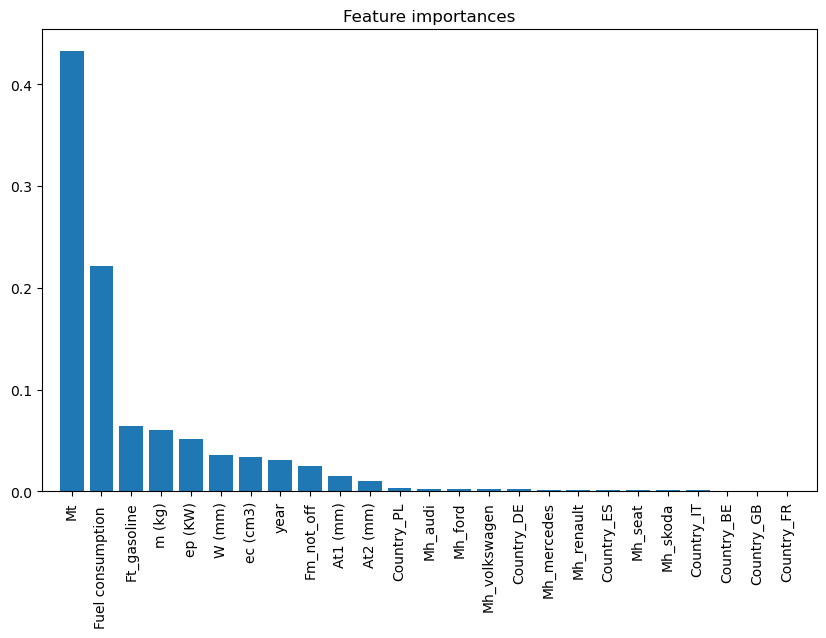

In [9]:
# Check feature importance

# Get feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(X_train.shape[1]):
    print(f"{f + 1}. Feature {indices[f]} ({importances[indices[f]]})")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


In [6]:
# Step 5: Cross-validation (5-fold cross-validation to check generalization)
cv_scores = cross_val_score(rf_model, X, y, cv=5, scoring='r2')
cv_mean = np.mean(cv_scores)

print(f"Cross-validated R-squared: {cv_mean}")

Cross-validated R-squared: 0.9285935010743126


In [12]:
from sklearn.model_selection import GridSearchCV

# n_estimators: 5,10,20. max depth: none, 5,15,20. min samples split: 2,5,5. min samples leaf: 1,2,3 --> one hour and still no results. 
param_grid = {
     'n_estimators': [3, 5, 10],
     'max_depth': [None, 2, 4, 6],
     'min_samples_split': [2, 3, 5],
     'min_samples_leaf': [1, 2, 3]}

grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1)
grid_search.fit(X_train, y_train)

print(f"Best parameters from GridSearch: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

KeyboardInterrupt: 

# 8 - Performative comparison among LR, Trees and Random Forests

In [9]:
# load libraries

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import time

# import data

df = pd.read_parquet(r'C:\Users\alexa\Downloads\ProjectCO2--no Gibhub\EU_Alex\Data\df_2019d6_hot_encoded.parquet')



Define Performance Metrics

- Mean Squared Error (MSE): Measures the average squared difference between predicted and actual values. Lower values are better.
- R-squared (R²): Indicates the proportion of variance explained by the model. Higher values (closer to 1) are better.
- Cross-validated R-squared (cross_val_score): Helps evaluate how the model generalizes to unseen data.



In [10]:

# df is the DataFrame
X = df.drop(columns=['target_Ewltp'])  # Features (drop the target variable)
y = df['target_Ewltp']  # Target variable

# Split data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Intantiate models

lr_model = LinearRegression()
dt_model = DecisionTreeRegressor(random_state=42)
rf_model = RandomForestRegressor(n_estimators=10, random_state=42)

models = {
    'Linear Regression': lr_model,
    'Decision Tree': dt_model,
    'Random Forest': rf_model
}

# Store results
results = {}

for name, model in models.items():
    start_time = time.time()  # Track time
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    cv_r2 = cross_val_score(model, X, y, cv=5, scoring='r2').mean()

    # Store results
    results[name] = {
        'Test MSE': mse,
        'Test R-squared': r2,
        'Cross-validated R-squared': cv_r2,
        'Training Time (seconds)': time.time() - start_time
    }

# Compare results

comparison_df = pd.DataFrame(results).T
print(comparison_df)

                   Test MSE  Test R-squared  Cross-validated R-squared  \
Linear Regression  0.182323        0.802891                   0.732700   
Decision Tree      0.018853        0.979618                   0.903063   
Random Forest      0.015820        0.982897                   0.928594   

                   Training Time (seconds)  
Linear Regression                20.506538  
Decision Tree                   173.082139  
Random Forest                  1137.461714  


Interpretation:

Test MSE: Lower values indicate better performance on unseen data.
Test R-squared: Higher values indicate better fit on the test set.
Cross-validated R-squared: Consistent R² values across folds indicate stability in the model’s predictive power.
Training Time: Compare the computational efficiency of each model.

In [7]:
# Visualization

# Plot residuals
plt.scatter(y_test, y_test - y_pred)
plt.title(f'Residuals Plot for {name}')
plt.xlabel('Actual')
plt.ylabel('Residuals')
plt.show()

# Feature importance (for random forest)
importances = rf_model.feature_importances_
plt.barh(X.columns, importances)
plt.title('Feature Importance (Random Forest)')
plt.show()



NameError: name 'plt' is not defined

Conclusions: 

If Random Forest consistently performs better with lower MSE and higher R² but takes longer to train, it might be worth using for its predictive power.
Linear Regression might be preferable if you prioritize simplicity and speed.
Decision Trees might offer a middle ground but could suffer from overfitting without pruning.



# 